In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from sklearn.svm import SVR

In [3]:
from telepyth import TelepythClient
tp = TelepythClient()

In [7]:
from quffka.kernels import *

In [6]:
from quffka.kernels import approximate_arccos0_kernel, approximate_arccos1_kernel, \
                    approximate_rbf_kernel, arccos0_kernel, arccos1_kernel
from .rom import generate_rademacher_weights, generate_gort_weights
from .utils import generate_random_weights, generate_householder_weights, \
                    generate_butterfly_weights, radius, butterfly_params, \
                    generate_halton_weights
from .mapping import fast_batch_approx_rbf, fast_batch_approx_arccos1, \
                fast_batch_approx_arccos0
from .sklearn.metrics.pairwise import rbf_kernel

ImportError: cannot import name 'approximate_arccos0_kernel'

In [4]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(8)
print(mkl_get_max_threads())

1
8


# CCPP

In [13]:
dataset_name = 'CCPP'
dataset, d = get_dataset(dataset_name, 8500)
xtrain, ytrain, xtest, ytest = dataset
n1 = xtrain.shape[0]
n2 = xtest.shape[0]
# maxv = np.max(np.vstack((xtrain, xtest)))
# xtrain /= maxv
# xtest /= maxv

## Classification accuracy

In [14]:
clf_rbf = SVR()
clf_rbf.fit(xtrain, ytrain)
exact_rbf = clf_rbf.score(xtest, ytest)
exact_rbf

0.94152717756622817

In [15]:
clf_rbf = SVR(gamma=0.0017547908179602926)
clf_rbf.fit(xtrain, ytrain)
exact_rbf = clf_rbf.score(xtest, ytest)
exact_rbf

0.90098155989821815

In [ ]:
{'LETTER': 0.060666809275491576,
 'Powerplant': 0.0017547908179602926,
 'USPS': 0.018610472828290418}

In [9]:
clf_rbf = SVR(gamma=0.0017547908179602926)
clf_rbf.fit(xtrain, ytrain)
exact_rbf = clf_rbf.score(xtest, ytest)

clf_arccos1 = SVR(kernel=arccos1_kernel)
clf_arccos1.fit(xtrain, ytrain)
exact_arccos1 = clf_arccos1.score(xtest, ytest)

clf_arccos0 = SVR(kernel=arccos0_kernel)
clf_arccos0.fit(xtrain, ytrain)
exact_arccos0 = clf_arccos0.score(xtest, ytest)

In [10]:
print(exact_rbf, exact_arccos1, exact_arccos0)

0.900981559898 0.940529091098 0.880310435677


In [ ]:
def get_scores(dataset, approx_type, estimator, K, runs):
    xtrain, ytrain, xtest, ytest = dataset
    n = xtrain.shape[1]
    n1 = xtrain.shape[0]
    n2 = xtest.shape[0]
    stacked_train = np.asfortranarray(np.vstack([xtrain, xtrain])).T
    stacked_train_test = np.asfortranarray(np.vstack([xtest, xtrain])).T
    
    rbf_scores = np.empty((K, runs))
    arccos_scores = np.empty((K, runs))
    arccos0_scores = np.empty((K, runs))

    if approx_type == 'B simplex':
        stacked_train = np.asfortranarray(np.vstack([xtrain, xtrain])).T
        stacked_train_test = np.asfortranarray(np.vstack([xtest, xtrain])).T
        
    for k in tnrange(K):
        for j in tnrange(runs):
            t = 2 * (k+1)
            r = radius(n, t)
            b_params = butterfly_params(n, t)
            if approx_type == 'B simplex':
                rbf_precomputed = fast_batch_approx_rbf(stacked_train, n1, k+1, r, b_params)
                arccos_precomputed = fast_batch_approx_arccos1(stacked_train, n1, k+1, r, b_params)
                arccos0_precomputed = fast_batch_approx_arccos0(stacked_train, n1, k+1, r, b_params)

                rbf_precomputed_test = fast_batch_approx_rbf(stacked_train_test, n2, k+1, r, b_params)
                arccos_precomputed_test = fast_batch_approx_arccos1(stacked_train_test, n2, k+1, r, b_params)
                arccos0_precomputed_test = fast_batch_approx_arccos0(stacked_train_test, n2, k+1, r, b_params)
                
            else:
                if approx_type == 'random':
                    M, w = generate_random_weights(k+1, n)
                elif approx_type == 'ROM':
                    M, w = generate_rademacher_weights(k+1, n)
                elif approx_type == 'gort':
                    M, w = generate_random_weights(k+1, n)            
                elif approx_type == 'dense B':
                    M, w = generate_butterfly_weights(k+1, n)
                elif approx_type == 'halton':
                    M, w = generate_halton_weights(k+1, n)
                else:
                    raise Exception('no approx type specified')

                rbf_precomputed = approximate_rbf_kernel(xtrain, xtrain, M, w)
                arccos_precomputed = approximate_arccos1_kernel(xtrain, xtrain, M, w)
                arccos0_precomputed = approximate_arccos0_kernel(xtrain, xtrain, M, w)

                rbf_precomputed_test = approximate_rbf_kernel(xtest, xtrain, M, w)
                arccos_precomputed_test = approximate_arccos1_kernel(xtest, xtrain, M, w)
                arccos0_precomputed_test = approximate_arccos0_kernel(xtest, xtrain, M, w)

            clf_rbf_pre = estimator(kernel='precomputed')
            clf_rbf_pre.fit(rbf_precomputed, ytrain)
            rbf_scores[k][j] = clf_rbf_pre.score(rbf_precomputed_test, ytest)

            clf_arccos_pre = estimator(kernel='precomputed')
            clf_arccos_pre.fit(arccos_precomputed, ytrain)
            arccos_scores[k][j] = clf_arccos_pre.score(arccos_precomputed_test, ytest)

            clf_arccos0_pre = estimator(kernel='precomputed')
            clf_arccos0_pre.fit(arccos0_precomputed, ytrain)
            arccos0_scores[k][j] = clf_arccos0_pre.score(arccos0_precomputed_test, ytest)
            
    return rbf_scores, arccos_scores, arccos0_scores

In [11]:
K = 5
runs = 10

In [12]:
%%time
%%telepyth
halton_rbf_scores, halton_arccos_scores, halton_arccos0_scores = get_scores(dataset, 'halton', SVR, K, runs)


CPU times: user 15min 13s, sys: 54 s, total: 16min 7s
Wall time: 9min 34s


In [ ]:
%%time
%%telepyth
B_rbf_scores, B_arccos_scores, B_arccos0_scores = get_scores(dataset, 'B simplex', SVR, K, runs)
rom_rbf_scores, rom_arccos_scores, rom_arccos0_scores = get_scores(dataset, 'ROM', SVR, K, runs)
g_rbf_scores, g_arccos_scores, g_arccos0_scores = get_scores(dataset, 'random', SVR, K, runs)
gort_rbf_scores, gort_arccos_scores, gort_arccos0_scores = get_scores(dataset, 'gort', SVR, K, runs)

In [16]:
def plot_(scores_, labels, kernel_type, dataset_name, exact):
    fig = plt.figure()
    ax = fig.add_subplot('111')
    
    for i,scores in enumerate(scores_):
        x = 2 * (np.arange(0, K, 1) + 1) * (d + 1)
#         print(x)
        ci = np.empty((scores.shape[0], 2))
        mean = np.zeros(scores.shape[0])
        for j in range(scores.shape[0]):
            mean[j], ci[j,0], ci[j,1] = mean_confidence_interval(scores[j,:])
        ax.plot(x, mean, '.-', label=labels[i])
        ax.fill_between(x, np.maximum(0, ci[:, 0]), ci[:, 1], alpha = 0.3)
        
    ax.axhline(exact, linestyle='--', label='exact', color='black')
           
    ax.set_xlabel(r'nfeatures', fontsize=16)
    ax.set_ylabel(r'accuracy', fontsize=16)
    title = f'SVC accuracy using {kernel_type} kernel approximation, {dataset_name}'
    fig.suptitle(title, fontsize=16)
    ax.legend(loc='best', framealpha=0.1)
    plt.tight_layout(pad=3)
    plt.savefig('figure_data/acc/%s%s.pdf' % (dataset_name, kernel_type), dpi=1200, format='pdf')
    

[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]


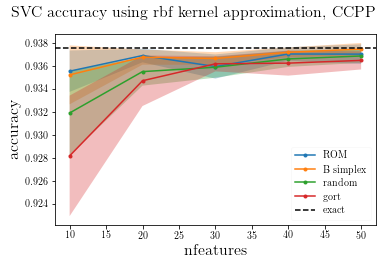

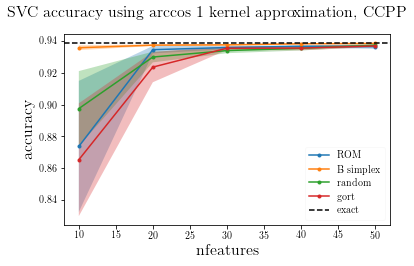

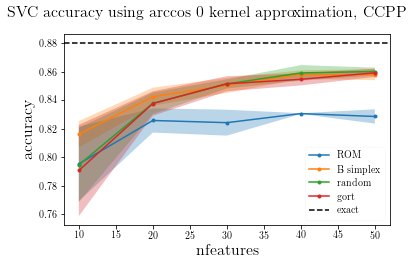

In [27]:
types = ['ROM', 'B simplex', 'random', 'gort']

rbf_scores = [rom_rbf_scores, B_rbf_scores, g_rbf_scores, gort_rbf_scores]
arccos_scores = [rom_arccos_scores, B_arccos_scores, g_arccos_scores, gort_arccos_scores]
arccos0_scores = [rom_arccos0_scores, B_arccos0_scores, g_arccos0_scores, gort_arccos0_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

In [28]:
scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos_scores)}}

In [29]:
np.savez(f'figure_data/acc/accuracy{dataset_name}', scores_dic)

In [30]:
exact = [exact_rbf, exact_arccos0, exact_arccos1]
np.save(f'figure_data/acc/exact{dataset_name}', np.array(exact))

[10 20 30 40 50]
[10 20 30 40 50]
[10 20 30 40 50]


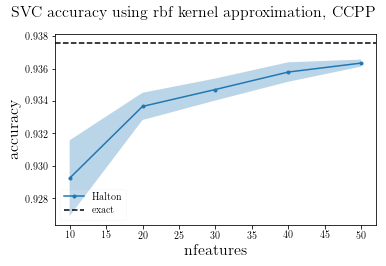

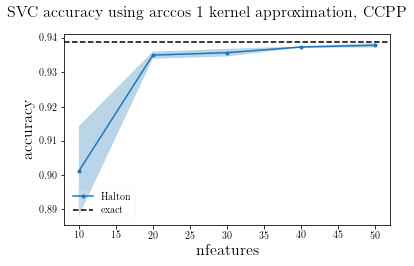

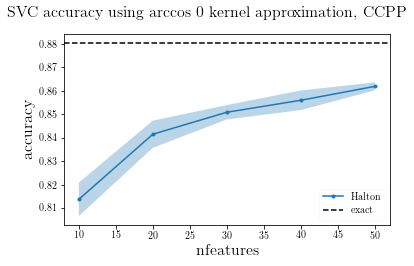

In [21]:
types = ['Halton']
rbf_scores = [halton_rbf_scores]
arccos0_scores = [halton_arccos0_scores]
arccos1_scores = [halton_arccos_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos1_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

In [19]:
scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos1_scores)}}

In [20]:
np.savez(f'figure_data/acc/haltonaccuracy{dataset_name}', scores_dic)